In [1]:
from __future__ import print_function
import librosa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
samples_per_chunk = 300
num_chunks_per_slice = 11
num_chunks_per_beat = 8

In [4]:
filename = "song.ogg"

In [5]:
y, sr = librosa.load(filename)

In [6]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [7]:
len(y)

5006112

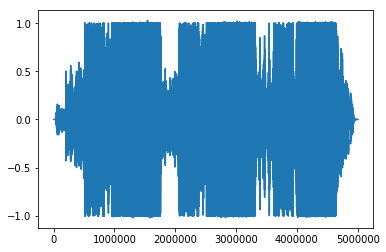

In [8]:
plt.plot(range(len(y)),y)

In [9]:
length = librosa.get_duration(y=y,sr=sr)

In [10]:
tempo = np.round(librosa.beat.tempo(y, sr=sr))
new_sample_rate = (tempo/200)*8000
y = librosa.resample(y, sr, new_sample_rate)

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [11]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
#This function takes an int representing the BPM, a float representing how long the song is in secs, and
#a long int representing the file size. This information is used to create a list containing the start 
#and endpoints for blocks.

def blockList(BPM, secs, fileSize,y):
    mins = secs / 60.0 #how many minutes long is the song
    numBeats = int(BPM * mins) #the number of beats in the song
    numChunks = numBeats * 8 #the total number of chunks
    chunkSize = int(fileSize / numChunks) #how many points there are in a chunk

    chunker = chunks(y, int(chunkSize))
    List = [np.abs(np.fft.fft(next(chunker)))[0:int(chunkSize/2)+1] for i in range(int(numChunks))]

    print("minutes   :", mins)
    print("num beats :", numBeats)
    print("num chunks:", numChunks)
    print("chunk size:", chunkSize)        
    
    return List, numChunks, numBeats
    

In [13]:
chunkedList, number_of_chunks, number_of_beats = blockList(tempo, length, len(y), y)

minutes   : 3.7839092970521544
num beats : 514
num chunks: 4112
chunk size: 300


In [14]:
def sliding_window_gen(l, noc, ncps): #parameters: the list of numpy arrays, the number of chunks, and the number of chunks per slice
    for i in range(int(ncps/2)): #pad both sides of the input list with numpy arrays of zeros 
        l.insert(0, np.zeros(samples_per_chunk))
        l.append(np.zeros(samples_per_chunk))
    for i in range(noc):
        yield np.concatenate(l[i:i+ncps])

In [15]:
window_generator = sliding_window_gen(chunkedList,number_of_chunks, num_chunks_per_slice)

In [16]:
current_window = next(window_generator)

In [17]:
print(current_window)

[0. 0. 0. ... 0. 0. 0.]


In [34]:
import json
import numpy as np
from sympy import *
init_printing(use_latex=True)
import scipy.spatial.distance as ssd
from pprint import pprint
    
def jsonInterpretor(filename, beats):
    
    with open(filename) as f:
        data = json.load(f)          
  
    #beats = 300 #the number of beats
    notes = "_notes"
    time = "_time"
    lineIndex = "_lineIndex" #row
    lineLayer = "_lineLayer" #column
    types = "_type" #0 is one color and 1 is the other
    cutDirection = "_cutDirection"#9 cut directions

    MatrixRows = beats * num_chunks_per_beat

    FinalMatrix = np.zeros(shape=(MatrixRows,32))#will hold all of the vectors, should be 32 by the number of beats * 8

    j = 0; #index for .json notes
    beat = 0.0 #1/8 increments for keeping track of time
    
    
    #data[notes][3][time]
    for i in range(MatrixRows):
        if np.round(data[notes][j][time]*num_chunks_per_beat)/num_chunks_per_beat == beat:
            if data[notes][j][types] == 0: #if the color is equal to 0, start at zero
                    FinalMatrix[i][data[notes][j][lineIndex]]+=1
                    FinalMatrix[i][data[notes][j][lineLayer]+4]+=1
                    FinalMatrix[i][data[notes][j][cutDirection]+7]+=1
            elif data[notes][i][types] == 1: #else the color is equal to 1, add 16
                    FinalMatrix[i][data[notes][j][lineIndex]+16]+=1
                    FinalMatrix[i][data[notes][j][lineLayer]+4+16]+=1
                    FinalMatrix[i][data[notes][j][cutDirection]+7+16]+=1
            j+=1#increment the note cntr after updating the matrix with the appropriate ones
        beat +=.125#increment the beat cntr after every 'i' increment
    
    return FinalMatrix;



In [63]:
len(A)

In [87]:
A = jsonInterpretor('Hard.json', number_of_beats)
def beatmap_training_gen(A): #slice matrix into its rows
    for i in range(len(A)):
        yield A[i:(i+1)]

In [81]:
beatmap_training_generator = beatmap_training_gen(A)

In [82]:
for i in range(163):
    next(beatmap_training_generator)

In [85]:
b = next(beatmap_training_generator)

In [86]:
b

array([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])